### load the monthly CMIP5 ts (surface temperature) RAW files, do some data cleaning and plot IPCC-AR5 figure

[IPCC-AR5 Figure 12.5](http://www.climatechange2013.org/images/figures/WGI_AR5_Fig12-5.jpg)

* still trouble with dates till 2300 using cftime so convert all times to time grid in 'months since 1960-01-01'
* NorESM1-ME(rcp85) and CCSM4(rcp45,rcp85) have trouble with lat grid when using xr.open_mfdataset, see this [pangeo issue](https://github.com/pydata/xarray/issues/2217), so they have been concatenated using ncrcat. That is why we must check grid sizes
in the 'get_datasets' function
* we have allowed models with one missing year at the start or end of the time interval
* there are two modes to use this:  1. save and read from intermediate netcdf files 2. read all data and plot (may take a long time)

In [1]:
import xarray as xr
import numpy as np
%matplotlib inline
from glob import glob
from os import system
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
from datetime import date
from pathlib import Path
xr.set_options(enable_cftimeindex=True)
xr.__version__

'0.10.4'

### Function definitions are all in the next cell, you may want to collapse it on first reading

In [6]:
# In this one cell are the functions - could be kept separately, or collapsed

def find_models_runs(base_path,var,scenario,century):
    """
    Search for all files in path matching the variable, scenario and century 
    returns:
         models: list of model names 
         runs:   list of run name paths, one for each model 
    """
    from glob import glob
    path = base_path + '/*/' + scenario + '/atmos/mon/' + var
    allruns = glob(path + '/r?????/*.nc')  # note, don't want /r*/*.nc because r10i1p1 is not wanted
    
    # We need to make a list of the models and pick one ensemble member (run) for each model
    fmodels = []
    for run in allruns:
        model = run.split("/")[-7]
        fmodels += [model]
    
    umodels = list(set(sorted(fmodels)))
    
    runs = []
    for model in umodels:
        path = base_path + model + '/' + scenario + '/atmos/mon/' + var + '/r?????'
        allruns = sorted(glob(path))
        runs += [allruns[0]]
        
    return umodels, runs

def get_start_dates(umodels,runs,toprint=False):
    """
    Find the start_date for each model by parsing the first file in the run path
    Print out units and calendar if toprint=True
    returns:
        start_dates: a list of one start_date per model
    """  
    start_dates=[]
    for idx,model in enumerate(umodels):
        path = runs[idx]
        files = sorted(glob(path + '/*.nc'))
        file0 = files[0]   

        # open first file to get start time
        dss = xr.open_dataset(file0,decode_times=True,autoclose=True)
        start_date = str(dss.time.values[0])
        start_dates += [start_date] 

        # open again to get the units and calendar:
        dss = xr.open_dataset(file0,decode_times=False,autoclose=True)
        
        if toprint:
            fstr = '{:2} {:18} units = {:.21} \t calendar =  {:20} start_date = {:.30}'
            print(fstr.format(idx,model,dss.time.attrs['units'],dss.time.attrs['calendar'],start_date))
            
    return start_dates

def get_datasets(var, century, umodels, runs, start_dates, toprint=False):
    """
    Identify models which are useful, deleting those which do not span the interval or have other
        problems
    returns:  
        ds : list of all good DataArrays 
        models: corresponding list of the good models
    """  
    slist = century.split('-')
    [start_year, stop_year] = list(map(int, slist))
    ds = []
    bad_models =[]
    #for model in tqdm(umodels):
    for idx,model in enumerate(umodels):
        start_date = start_dates[idx]
        path = runs[idx]
        files = sorted(glob(path + '/*.nc'))
        num_files = len(files)
        # open single file once to get expected lon,lat sizes
        dss = xr.open_dataset(files[0],decode_times=False,autoclose=True)
        nx0 = dss.lon.shape[0]; ny0 = dss.lat.shape[0]

        # open all files, should concatenate in time
        dss = xr.open_mfdataset(files,concat_dim='time',decode_times=False,autoclose=True)
        nt = dss.time.shape[0]; nx = dss.lon.shape[0]; ny = dss.lat.shape[0]
        if not ((nx==nx0) and (ny==ny0)):
            print('trouble with model',model,'real dims:',nx0,ny0,'mfdataset dims:',nx,ny)
            bad_models += [model]

        dss['time'] = to_enso(start_date,nt)
        
        # following needed only for tas, not ts
        #if 'height' in dss.coords:
        #   del dss['height']
        #ds += [dss[var]]

        tfirst = enso2date(dss.time[0].values)
        tlast = enso2date(dss.time[-1].values)
        if (int(str(tfirst)[0:4]) > start_year):
            print('trouble with model',model,'since start date is past',start_year)
            bad_models += [model]

        if (int(str(tlast)[0:4]) < stop_year-1):
            print('trouble with model',model,'since stop date is before',stop_year)
            bad_models += [model]

        if toprint:
            fstr = '{:2g}: {:18} num_files={:2g}, {:12} to {:12}, nx={:4g}, ny={:4g}, nt={:5g},{:5.0f}Mb'
            print(fstr.format(idx,model,num_files,tfirst,tlast,nx,ny,nt,dss.nbytes/ 1e6))
            
    bad_models = sorted(list(set(bad_models)))  
    for model in bad_models:
        idx = models.index(model)
        del models[idx],ds[idx]
        
    return ds, models

def regrid_all(ds,umodels,century):
    """
    Define common grid and use xESMF to regrid all datasets 
    returns:
        data_2x2: a list of datasets on the common grid
    """      
    # regrid all lon,lat data to a common 2x2 grid
    import xesmf as xe
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89,89, 2)),
                         'lon': (['lon'], np.arange(-179,179,2)),
                        })
    
    slist = century.split('-')
    [start_year, stop_year] = list(map(int, slist))
    start = to_enso(str(start_year)+'-01-16')[0]
    stop  = to_enso(str(stop_year)+'-01-16')[0]
    data_2x2 =[]
    for model,dss in zip(umodels,ds):
        #print(model,'nt=',dss.time.shape[0])
        regridder = xe.Regridder(dss, ds_out, 'bilinear', periodic=True, reuse_weights=True )
        data_2x2 += [regridder(dss.sel(time=slice(start, stop)))]
    return data_2x2

def concat_all(ds_2x2,umodels):
    """
    Concatenates all of the good models into one DataArray
    """  
    dsall = xr.concat(ds_2x2,dim='model') #,coords=['time','lat','lon'])
    dsall['names'] = ('model',umodels)
    return dsall

def compute_global_mean(danom):
    """
    Weights each grid point by the cos(latitude), computes global mean, normalizing by global mean of the weights
    returns:
        DataArray:  global mean for each model
    """  
    coslat = np.cos(np.deg2rad(danom.lat))
    d_ones = xr.ones_like(danom)
    weight_mean = (d_ones*coslat).mean(['lat','lon'])
    return (danom * coslat).mean(['lat','lon'])/weight_mean

# Once cftime is working properly the following functions could be replaced
#   (we need to be able to use resample, etc)
def monthly2yearly(century,dsall):
    """
    converts a DataArray on a monthly grid to one on a yearly grid, replacing the time grid
    """  
    slist = century.split('-')
    [start_year, stop_year] = list(map(int, slist))
    num_of_bins = dsall.time.shape[0]/12
    dnew = dsall.groupby_bins('time', num_of_bins).mean('time')
    dyearly = dnew.rename({'time_bins':'time'}) 
    dyearly['time'] = start_year + np.arange(dyearly.time.shape[0])
    return dyearly

def to_enso(start_time,nt=1):
    """
    Parse the time grid of a Dataset and replace by an enso time grid (months since 1960).
    """
    import numpy as np
    # get the reference year from start_time
    ryear,rmonth,rday = start_time[0:10].split('-')
    return (int(ryear)-1960)*12 + int(rmonth) - 0.5 + np.arange(0,nt)

def enso2date(T0,ryear=1960,leap=True):
    """
    Print the date corresponding to an enso-time (months since 1960). The reference year can be changed.
    """
    norm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    iy = ryear + int(T0/12)
    if T0 < 0:
        iy = iy - 1
    res = T0 - (iy - ryear)*12
    im = int(res) + 1
    if im == 13:
        im = 1
        iy = iy + 1
    if leap & (im == 2) &  (iy % 4 == 0 ):   
        id = 1 + int(29 * (res - int(res)))
    else:
        id = 1 + int(norm[im-1] * (res - int(res)))
    return str(iy)+'/'+str(im)+'/'+str(id)    

In [8]:
var = 'ts'   # about 55 Gb
#var = 'tas'   # about 47 Gb
my_system = True
#base_path = '/net/haden/d3/naomi/Raw/'  # about 2.8 Tb, includes ( 2d: ts,tas,pr,evspsbl,ps and 3d: hus,ua,va)
base_path = '/d1/naomi/Raw-ts/'

if my_system:  # save and read from intermediate netcdf files 
    read_data = False  # set to True if netcdf files need to be recomputed
    plot_global = True
    save_final_netcdfs = True
    plot_from_netcdfs = True
else:          # read all data and plot (may take a long time)
    read_data = True
    plot_global = True
    save_final_netcdfs = False
    plot_from_netcdfs = False


In [4]:
if read_data:   
    # Each of the following scenarios and time periods has a different subset of CMIP5 models available
    # These subsets are different for each variable chosen
    # YOU CAN PICK AND CHOOSE WHICH TO CALCULATE/PLOT
    all = []
    #all += [['historical','1861-2005']]
    #all += [['historical','1850-1860']]
    #all += [['rcp85','2006-2099']]
    all += [['rcp85','2100-2300']]
    #all += [['rcp45','2006-2099']]
    #all += [['rcp45','2100-2300']]
    
    ds_master = []
    for scenario,century in all:
        first_step = True
        if first_step:
            print('SCENARIO=',scenario,'TIME RANGE',century)
            models, runs = find_models_runs(base_path,var,scenario,century)
            print('total number of models available:',len(models),'\n',models)

            start_dates = get_start_dates(models,runs,toprint=True)

            ds,good_models = get_datasets(var,century,models,runs,start_dates,toprint=True)
            
            print('\n','number of good models with data in the specified time range:',len(good_models),'\n',good_models)
            ds_2x2 = regrid_all(ds,good_models,century)

        dsall = concat_all(ds_2x2,good_models)
        
        print(dsall.nbytes / 1e9,'Gb, ', '(models, nt, nlat, nlon)=',dsall.shape)

        dyear = monthly2yearly(century,dsall)
        ts_global = compute_global_mean(dyear)
        sctype = scenario+':'+century
        ts_global.attrs = [('sctype',sctype)]
        
        ds_master += [ts_global.to_dataset(name=var)]
        
        if save_final_netcdfs:
            nc_file = var+'-global_'+sctype+'.nc'
            print('saving file:',nc_file,'\n\n')
            ts_global.to_dataset(name=var).to_netcdf(nc_file,encoding={'time':{'dtype':'float32'}})

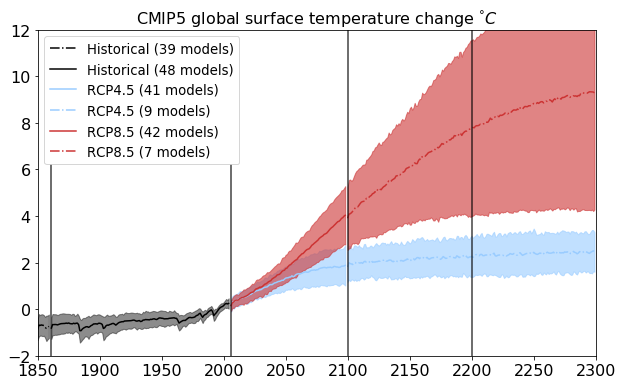

In [5]:
if plot_global:
    l = ['historical:1850-1860','historical:1861-2005','rcp45:2006-2099','rcp45:2100-2300','rcp85:2006-2099','rcp85:2100-2300']
    sctypelist = l; markerlist = l.copy(); colorlist = l.copy(); tnamelist = l.copy(); alphalist = l.copy()
    for idx,sctype in enumerate(sctypelist):
        markerlist[idx] = '-'; alphalist[idx] = 0.6
        if 'hist' in sctype:
            colorlist[idx] = 'black'; alphalist[idx] = 0.45; tnamelist[idx] = 'Historical'
            if '1850-1860' in sctype:
                markerlist[idx] = '-.'
        if 'rcp45' in sctype:
            colorlist[idx] = '#99CCFF'; tnamelist[idx] = 'RCP4.5'  
        if 'rcp85' in sctype:
            colorlist[idx] = '#CC3333';  tnamelist[idx] = 'RCP8.5'  
        if '2100-2300' in sctype:
                markerlist[idx] = '-.'
    
    # find the climatology dataset:    
    if plot_from_netcdfs:
        hfile = var + '-global_historical:1861-2005.nc'
        hvar = xr.open_dataset(hfile,autoclose=True)
    else:
        for ds in ds_master:
            if 'historical:1861-2005' in ds[var].attrs['sctype']:
                hvar = ds
  
    hmodels = hvar.names.values.tolist()

    # for each model, compute the time mean from the climatology interval: 1986-2005
    tgm = hvar.sel(time=slice(1986,2005)).mean('time')
    
    # calculate the model mean tgm, for use in models which do not have a climatological reference run
    tgm0 = tgm[var].mean('model')

    plt.figure(figsize=(10,6))
    rcParams.update({'font.size': 16})
        
    for idx,sctype in enumerate(sctypelist):
        tname = tnamelist[idx];marker=markerlist[idx];color=colorlist[idx];alpha=alphalist[idx]
        tstat = False
        if plot_from_netcdfs:
            tfile = Path(var+'-global_'+sctype+'.nc')
            if tfile.is_file():
                tvar = xr.open_dataset(tfile)
                tstat = True                
        else:           
            for ds in ds_master:
                if sctype in ds[var].attrs['sctype']:
                    tvar = ds
                    tstat = True
        if tstat:
            year = tvar.time.values

            #find the time mean for all models in this scenario:century
            tmean = 0*tvar[var].mean('time')
            for idx,model in enumerate(tvar.names.values):
                if model in hmodels:
                    hidx = hmodels.index(model)
                    tmean[idx] = tgm[var][hidx]
                else:
                    tmean[idx] = tgm0

            num_models = tvar[var].shape[0]
            range5 = 1.64*(tvar - tmean)[var].std('model')
            tvar_mean = (tvar - tmean)[var].mean('model')
            tvar_95 = tvar_mean + range5
            tvar_05 = tvar_mean - range5
            label = tname+' ('+str(num_models)+' models)'
            plt.plot(year, tvar_mean, marker, color=color, label=label)
            plt.fill_between(year, tvar_05, tvar_95, color=color, alpha=alpha)

    plt.plot((1861, 1861), (-2, 6.2), 'k-', linewidth=1.5, alpha=0.75)
    plt.plot((2006, 2006), (-2, 6.2), 'k-', linewidth=1.5, alpha=0.75)
    plt.plot((2100, 2100), (-2, 12), 'k-', linewidth=1.5, alpha=0.75)
    plt.plot((2200, 2200), (-2, 12), 'k-', linewidth=1.5, alpha=0.75)
    plt.ylim(-2,12) 
    plt.xlim(1850,2300) 
    vtitle = r'CMIP5 global surface air temperature change $^\degree C$'
    if var == 'ts': 
        vtitle = r'CMIP5 global surface temperature change $^\degree C$'
    plt.title(vtitle,fontsize=16)
    plt.legend(loc='upper left',fontsize='small')
    figfile = 'global_' + var + '.png'
    plt.savefig(figfile)